In [1]:
from experiments.partial import build_partial, plot_partial

from lafomo.datasets import DrosophilaSpatialTranscriptomics, ToySpatialTranscriptomics
from lafomo.models import MultiOutputGP
from lafomo.trainers import PartialPreEstimator
from lafomo.plot import plot_spatiotemporal_data
from lafomo.utilities.torch import spline_interpolate_gradient, softplus

from matplotlib import pyplot as plt
import torch
from lafomo.configuration import VariationalConfiguration

In [2]:
drosophila = True

if drosophila:
    data = 'dros-kr'
    dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')
    params = dict(lengthscale=10,
                  sensitivity=0.0970,
                  decay=0.0764,
                  diffusion=0.0015,
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=False,
                  clamp=True)
else:
    data = 'toy-spatial'
    dataset = ToySpatialTranscriptomics(data_dir='../../../data')
    params = dict(lengthscale=0.3,
                  sensitivity=1,
                  decay=0.1,
                  diffusion=0.01,
                  natural=False,
                  clamp=False)
lfm, trainer, plotter = build_partial(
    dataset,
    params)
    # reload=f'../../../experiments/{data}/partial/0savedmodel')


t_sorted, dp [53.925 60.175 66.425 72.675 78.925 85.175 91.425 97.675] 6.25
x dp is set to 1.0
t_sorted, dp [25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5
 81.5 82.5 83.5 84.5 85.5 86.5 87.5 88.5] 1.0


8 64


/Users/jacob/Documents/proj/torchcubicspline/torchcubicspline/interpolate.py:277: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  ../aten/src/ATen/native/BucketizationUtils.h:25.)
  index = torch.bucketize(t.detach(), self._t) - 1


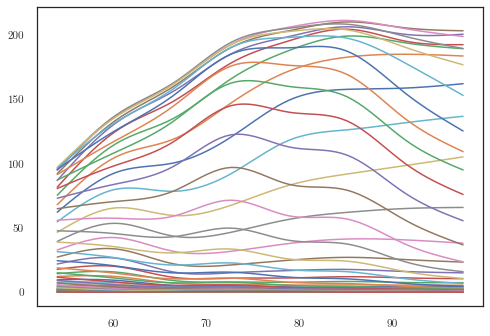

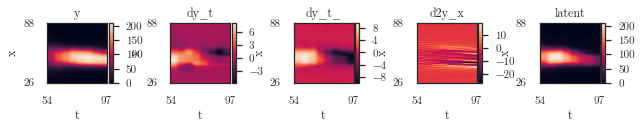

In [3]:
tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
print(num_t, num_x)
y_target = trainer.y_target[0]
y_matrix = y_target.view(num_t, num_x)

dy_t = list()
for i in range(num_x):
    t = tx[0][::num_x]
    y = y_matrix[:, i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, _ = \
        spline_interpolate_gradient(t, y)
    plt.plot(t_interpolate, y_interpolate)
    dy_t.append(y_grad)
dy_t = torch.stack(dy_t)

d2y_x = list()
dy_x = list()
for i in range(num_t):
    t = tx[1][:num_x]
    y = y_matrix[i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, y_grad_2 = \
        spline_interpolate_gradient(t, y)
    d2y_x.append(y_grad_2)
    dy_x.append(y_grad)

d2y_x = torch.stack(d2y_x)
dy_x = torch.stack(dy_x)[..., ::10, 0].reshape(1, -1)
d2y_x = d2y_x[..., ::10, 0].reshape(1, -1)
dy_t = dy_t[..., ::10, 0].t().reshape(1, -1)

def pde_func(y, u, sensitivity, decay, diffusion):
    # y (1, 1681) u (25, 1, 41, 41) s (25, 1)
    dy_t = (sensitivity * u.view(u.shape[0], -1) -
            decay * y.view(1, -1) +
            diffusion * d2y_x)
    return dy_t

dy_t_ = pde_func(
    trainer.y_target,
    torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).unsqueeze(0).repeat(25, 1),
    torch.tensor(params['sensitivity']).unsqueeze(0).repeat(25, 1),
    torch.tensor(params['decay']).unsqueeze(0).repeat(25, 1),
    torch.tensor(params['diffusion']).unsqueeze(0).repeat(25, 1))[0]

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
axes = plot_spatiotemporal_data(
    [
        trainer.y_target.view(num_t, num_x).t(),
        dy_t.reshape(num_t, num_x).t(),
        dy_t_.view(num_t, num_x).t(),
        d2y_x.view(num_t, num_x).t(),
        torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).view(num_t, num_x).t(),
    ],
    extent, titles=['y', 'dy_t', 'dy_t_', 'd2y_x', 'latent']
)

In [4]:
pre_estimator = PartialPreEstimator(
    lfm, trainer.optimizers, dataset, pde_func,
    input_pair=(trainer.tx, trainer.y_target), target=dy_t.t()
)

In [5]:
lfm.pretrain(True)
trainer.plot_outputs= True
pre_estimator.train(100, report_interval=10)

Epoch 001/100 - Loss: 18.32 (18.32 0.00) kernel: [[[ 9.900005   10.09999496]]]
Epoch 011/100 - Loss: 11.21 (10.26 0.95) kernel: [[[10.54001534 10.56791471]]]
Epoch 021/100 - Loss: 7.76 (7.38 0.38) kernel: [[[11.44291011 10.73529461]]]
Epoch 031/100 - Loss: 6.43 (6.19 0.24) kernel: [[[12.42581651 10.90198764]]]
Epoch 041/100 - Loss: 5.78 (5.58 0.20) kernel: [[[13.41151949 11.18465044]]]
Epoch 051/100 - Loss: 5.40 (5.23 0.17) kernel: [[[14.40169674 11.37949178]]]
Epoch 061/100 - Loss: 5.14 (4.99 0.14) kernel: [[[15.33842424 11.56707086]]]
Epoch 071/100 - Loss: 4.95 (4.82 0.13) kernel: [[[16.16624201 11.76504672]]]
Epoch 081/100 - Loss: 4.79 (4.67 0.12) kernel: [[[16.87131729 11.97636251]]]
Epoch 091/100 - Loss: 4.66 (4.56 0.10) kernel: [[[17.50479256 12.16033338]]]


In [ ]:
xy = lfm.gp_model.variational_strategy.base_variational_strategy.inducing_points.squeeze()
# c = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_vec
c = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean
plt.scatter(xy[:, 0], xy[:, 1], c=c.detach())
plt.colorbar()

In [ ]:
lfm.pretrain(False)
trainer.train(30, report_interval=5)

Mean output variance: 0.6553731716582952
Test loss: 228.38448580579592
Q2: -0.290
Epoch 001/030 - Loss: 99.43 (99.34 0.09) kernel: [[[18.05183814 12.35737221]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Epoch 006/030 - Loss: 86.84 (86.77 0.07) kernel: [[[18.2257778  12.41926704]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Mean output variance: 0.8950296675316085
Test loss: 169.90390043564264
Q2: -0.300
Epoch 011/030 - Loss: 73.93 (73.87 0.05) kernel: [[[18.33106564 12.45673276]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Epoch 016/030 - Loss: 64.62 (64.58 0.03) kernel: [[[18.39473059 12.47938735]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928


In [ ]:
[softplus(param) for param in lfm.fenics_parameters]

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(dict(lfm.named_parameters())['gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_tril_mat'][0].detach())
plt.colorbar()

In [ ]:
from lafomo.utilities.torch import softplus
print(list(map(softplus, lfm.fenics_parameters)))

In [ ]:
from pathlib import Path
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

torch.Size([512, 1])


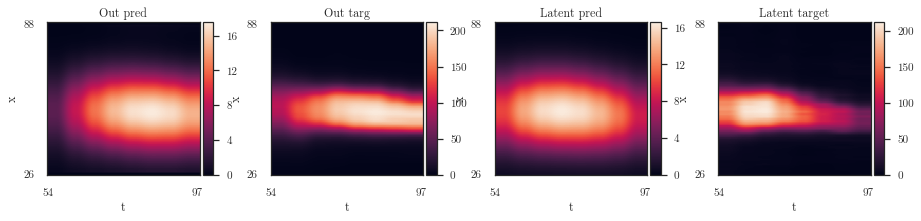

In [12]:
from lafomo.plot import plot_spatiotemporal_data
lfm.eval()
f = lfm(tx)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

# print(dataset.orig_data[:, 2])
l_target = torch.tensor(dataset.orig_data[:, 2])
l = lfm.gp_model(tx.t())
l_mean = l.mean.detach()
# plt.imshow(l_mean.view(num_t, num_x).transpose(0, 1))
print(l_mean.shape)
plot_spatiotemporal_data(
    [
        f_mean.view(num_t, num_x).t(),
        y_target.view(num_t, num_x).detach().t(),

        l_mean.view(num_t, num_x).t(),
        l_target.view(num_t, num_x).t()
    ],
    extent,
    titles=['Out pred', 'Out targ', 'Latent pred', 'Latent target']
)
plt.gca().get_figure().set_size_inches(15, 7)

In [ ]:
import torch
fig, ax = plt.subplots()
ax.imshow(torch.randn(10, 10))
ax.grid()
print(ax)